In [1]:
# dependencies
import pandas as pd
import numpy as np
from pupeyes import PupilProcessor, EyelinkReader

C:\Users\Hans Cheng\Documents\GitLab\pupeyes\src\pupeyes\aoi.py:22: UserWarning: Numba not available - falling back to non-optimized implementations.
  warnings.warn("Numba not available - falling back to non-optimized implementations.")


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# file name
path = 'example_data/003.asc'

# subject ID
subject = '003'

# msg format
msg_format = {'event':str, 'routine':str, 'block':str, 'trial':int}
delimiter = ' ' # delimiter for messages

# parse ASC data
raw = EyelinkReader(path, start_msg='start baseline', stop_msg = 'end TrialFeedback', msg_format=msg_format, delimiter=delimiter, add_cols={'subject':subject})

Reading ASC file example_data/003.asc: 100%|██████████| 2951560/2951560 [00:10<00:00, 289817.74it/s]


In [4]:
raw_samples = raw.get_samples()
raw_samples.head()

trialtime  trackertime      x      y    pp                        msg  \
0          0      2904673  878.0  269.8  4967  start baseline practice 1   
1          1      2904674  878.8  269.6  4971  start baseline practice 1   
2          2      2904675  879.1  269.4  4973  start baseline practice 1   
3          3      2904676  879.3  269.1  4972  start baseline practice 1   
4          4      2904677  879.4  268.8  4971  start baseline practice 1   

   msgtime  event   routine     block  trial subject  
0  2904673  start  baseline  practice      1     003  
1  2904673  start  baseline  practice      1     003  
2  2904673  start  baseline  practice      1     003  
3  2904673  start  baseline  practice      1     003  
4  2904673  start  baseline  practice      1     003

In [5]:
samp = raw_samples.copy()
samp = samp[samp.routine.isin(['baseline', 'trial_stim']) & samp.block.isin(['A', 'B', 'C', 'D', 'E'])].reset_index(drop=True)

# to-do: check works with trial_identifier=['trialid']
samp['trialid'] = samp['subject'] + '_' + samp['block'] + '_' + samp['trial'].astype(str)

In [ ]:
p = PupilProcessor(
    data=samp, 
    trial_identifier=['subject', 'block', 'trial'], 
    x_col = 'x',
    y_col = 'y',
    pupil_col = 'pp',
    time_col = 'trialtime',
    samp_freq = 1000,
    convert_pupil_size=True)
    
p = p.deblink().artifact_rejection().filter_position().smooth().interpolate(missing_threshold=0.5).baseline_correction(baseline_query='routine=="baseline"', baseline_range=[-100, None])

Pupil data converted to diameter with artificial d=5 and artificial size=5663
PupilProcessor initialized with 599898 samples
Pupil column: pp, Time column: trialtime, X column: x, Y column: y
Trial identifier: ['subject', 'block', 'trial'], Number of trials: 150


Artifact rejection: 100%|██████████| 150/150 [00:01<00:00, 101.86it/s]



 1 trials not artifact rejected due to missing pupil data:

   subject block  trial
0     003     E     16


Filtering based on gaze position: 100%|██████████| 150/150 [00:03<00:00, 38.83it/s]



 1 trials not filtered due to missing pupil data:

   subject block  trial
0     003     E     16


Smoothing: 100%|██████████| 150/150 [00:00<00:00, 170.56it/s]



 1 trials not smoothed due to missing pupil data:

   subject block  trial
0     003     E     16


Interpolating: 100%|██████████| 150/150 [00:01<00:00, 143.10it/s]



 10 trials not interpolated due to high missing values:

   subject block  trial
0     003     C     14
1     003     D     16
2     003     D     24
3     003     E      8
4     003     E     15
5     003     E     16
6     003     E     21
7     003     E     22
8     003     E     26
9     003     E     28


Baseline correction: 100%|██████████| 150/150 [00:01<00:00, 146.64it/s]



 10 trials not baseline corrected due to missing data:

   subject block  trial
0     003     C     14
1     003     D     16
2     003     D     24
3     003     E      8
4     003     E     15
5     003     E     16
6     003     E     21
7     003     E     22
8     003     E     26
9     003     E     28


In [7]:
trial = {'block':'C', 'trial':14}
p.plot_trial(
		trial=trial,
		x='trialtime',
		y=p.all_pupil_cols,
		hue='routine', 
		save = 'trial.pdf',
		interactive=True,
		plot_params={'layout':(4,2), 'x_title':'Time (ms)', 'y_title':'Pupil Size'})

Converting <class 'dict'> mask to DataFrame...


In [18]:
from puppy import PupilViewer

# Assuming you have a PupilProcessor instance called 'p'
viewer = PupilViewer(p)
viewer.run_server(debug=True)

Converting <class 'dict'> mask to DataFrame...
Converting <class 'dict'> mask to DataFrame...
Converting <class 'dict'> mask to DataFrame...


# Diagnostics


In [40]:
p.check_baseline_outliers(n_mad_baseline=5, outlier_by=['subject','block'], save='baseline.html')

Checking baseline pupil sizes for outliers:   0%|          | 0/5 [00:00<?, ?it/s]


 3 trials detected as baseline outliers:

     subject block  trial
30      003     B      1
90      003     D      1
120     003     E      1


In [84]:
p.plot_baseline(plot_by=['block'], show_outliers=True, save='baseline.html')

c:\Users\Hans Cheng\Documents\GitHub\pupil-aging\funcs\puppy\pupil.py:1584: UserWarning:

Outlier detection was performed by ['subject', 'block']. Plotting by ['block']. The plotted thresholds may be incorrect.



In [79]:
p.check_trace_outliers(y='pp_db_ar_xy_sm_it', outlier_by='block')

Checking trace outliers for pp_db_ar_xy_sm_it


Checking pupil traces for outliers:   0%|          | 0/150 [00:00<?, ?it/s]


 9 trials detected as outliers:

     subject block  trial
6       003     A      7
7       003     A      8
17      003     A     18
30      003     B      1
60      003     C      1
67      003     C      8
90      003     D      1
103     003     D     14
120     003     E      1


In [82]:
p.plot_spaghetti(y='pp_db_ar_xy_sm_it', plot_by=['subject','block'], show_outliers=True)

c:\Users\Hans Cheng\Documents\GitHub\pupil-aging\funcs\puppy\pupil.py:1855: UserWarning:

Outlier detection was performed by ['block']. Plotting by ['subject', 'block']. The plotted thresholds may be incorrect.



In [44]:
# plot a problematic trial according to the summary data
bad_trials = p.summary().query('run_deblink==False | run_speed==False | run_size==False | run_position==False | run_smooth==False | run_interpolate==False | run_baseline_correction==False | baseline_outlier==True | trace_outlier==True')[['subject','block','trial']]
bad_trials

subject block  trial
6       003     A      7
7       003     A      8
17      003     A     18
30      003     B      1
60      003     C      1
67      003     C      8
73      003     C     14
90      003     D      1
103     003     D     14
105     003     D     16
113     003     D     24
120     003     E      1
127     003     E      8
134     003     E     15
135     003     E     16
140     003     E     21
141     003     E     22
145     003     E     26
147     003     E     28

In [45]:
more_bad_trials = pd.DataFrame([
    {'subject':'003', 'block':'A', 'trial':18},
    {'subject':'003', 'block':'A', 'trial':20},
    {'subject':'003', 'block':'E', 'trial':18},
    {'subject':'003', 'block':'E', 'trial':14},
    {'subject':'003', 'block':'E', 'trial':11},

    ])

p.all_bad_trials = pd.concat([bad_trials, more_bad_trials])
p.all_bad_trials

subject block  trial
6       003     A      7
7       003     A      8
17      003     A     18
30      003     B      1
60      003     C      1
67      003     C      8
73      003     C     14
90      003     D      1
103     003     D     14
105     003     D     16
113     003     D     24
120     003     E      1
127     003     E      8
134     003     E     15
135     003     E     16
140     003     E     21
141     003     E     22
145     003     E     26
147     003     E     28
0       003     A     18
1       003     A     20
2       003     E     18
3       003     E     14
4       003     E     11

In [46]:
p = p.validate_trials(p.all_bad_trials)

In [47]:
# designed to help but not confine
p.final_data = p.data.query('valid==True & routine=="trial_stim"').reset_index(drop=True)
p.final_data['pp_final'] = p.final_data['pp_db_ar_xy_sm_it_bc']
p.final_data.head()

trialtime  trackertime      x      y        pp                   msg  \
0        984      3149725  957.8  490.3  4.863147  start trial_stim A 1   
1        985      3149726  957.9  489.3  4.865796  start trial_stim A 1   
2        986      3149727  958.0  488.5   4.87021  start trial_stim A 1   
3        987      3149728  958.1  488.3  4.873742  start trial_stim A 1   
4        988      3149729  958.0  488.8  4.874625  start trial_stim A 1   

   msgtime  event     routine block  ...  subject  trialid     pp_db  \
0  3149725  start  trial_stim     A  ...      003  003_A_1  4.863147   
1  3149725  start  trial_stim     A  ...      003  003_A_1  4.865796   
2  3149725  start  trial_stim     A  ...      003  003_A_1   4.87021   
3  3149725  start  trial_stim     A  ...      003  003_A_1  4.873742   
4  3149725  start  trial_stim     A  ...      003  003_A_1  4.874625   

   pp_db_ar  pp_db_ar_xy  pp_db_ar_xy_sm  pp_db_ar_xy_sm_it  \
0  4.863147     4.863147        4.866553           4.866553   
1  4.865796     4.865796        4.866945           4.866945   
2   4.87021      4.87021        4.867328           4.867328   
3  4.873742     4.873742        4.867703           4.867703   
4  4.874625     4.874625         4.86807            4.86807   

   pp_db_ar_xy_sm_it_bc  valid  pp_final  
0              0.009172   True  0.009172  
1              0.009564   True  0.009564  
2              0.009948   True  0.009948  
3              0.010323   True  0.010323  
4              0.010689   True  0.010689  

[5 rows x 21 columns]

In [48]:
p.save('mysubject.pkl')

In [49]:
# p2=PupilProcessor.load('mysubject.pkl')

In [50]:
# p3 = PupilProcessor(data=samp, trial_identifier=['subject', 'block', 'trial'])

# p3.copy().deblink()

# Statistical tests


In [51]:
import mne.stats as ms

127 trials. Minimum number of samples: 2996. Data will be padded to size: 127 x 2996


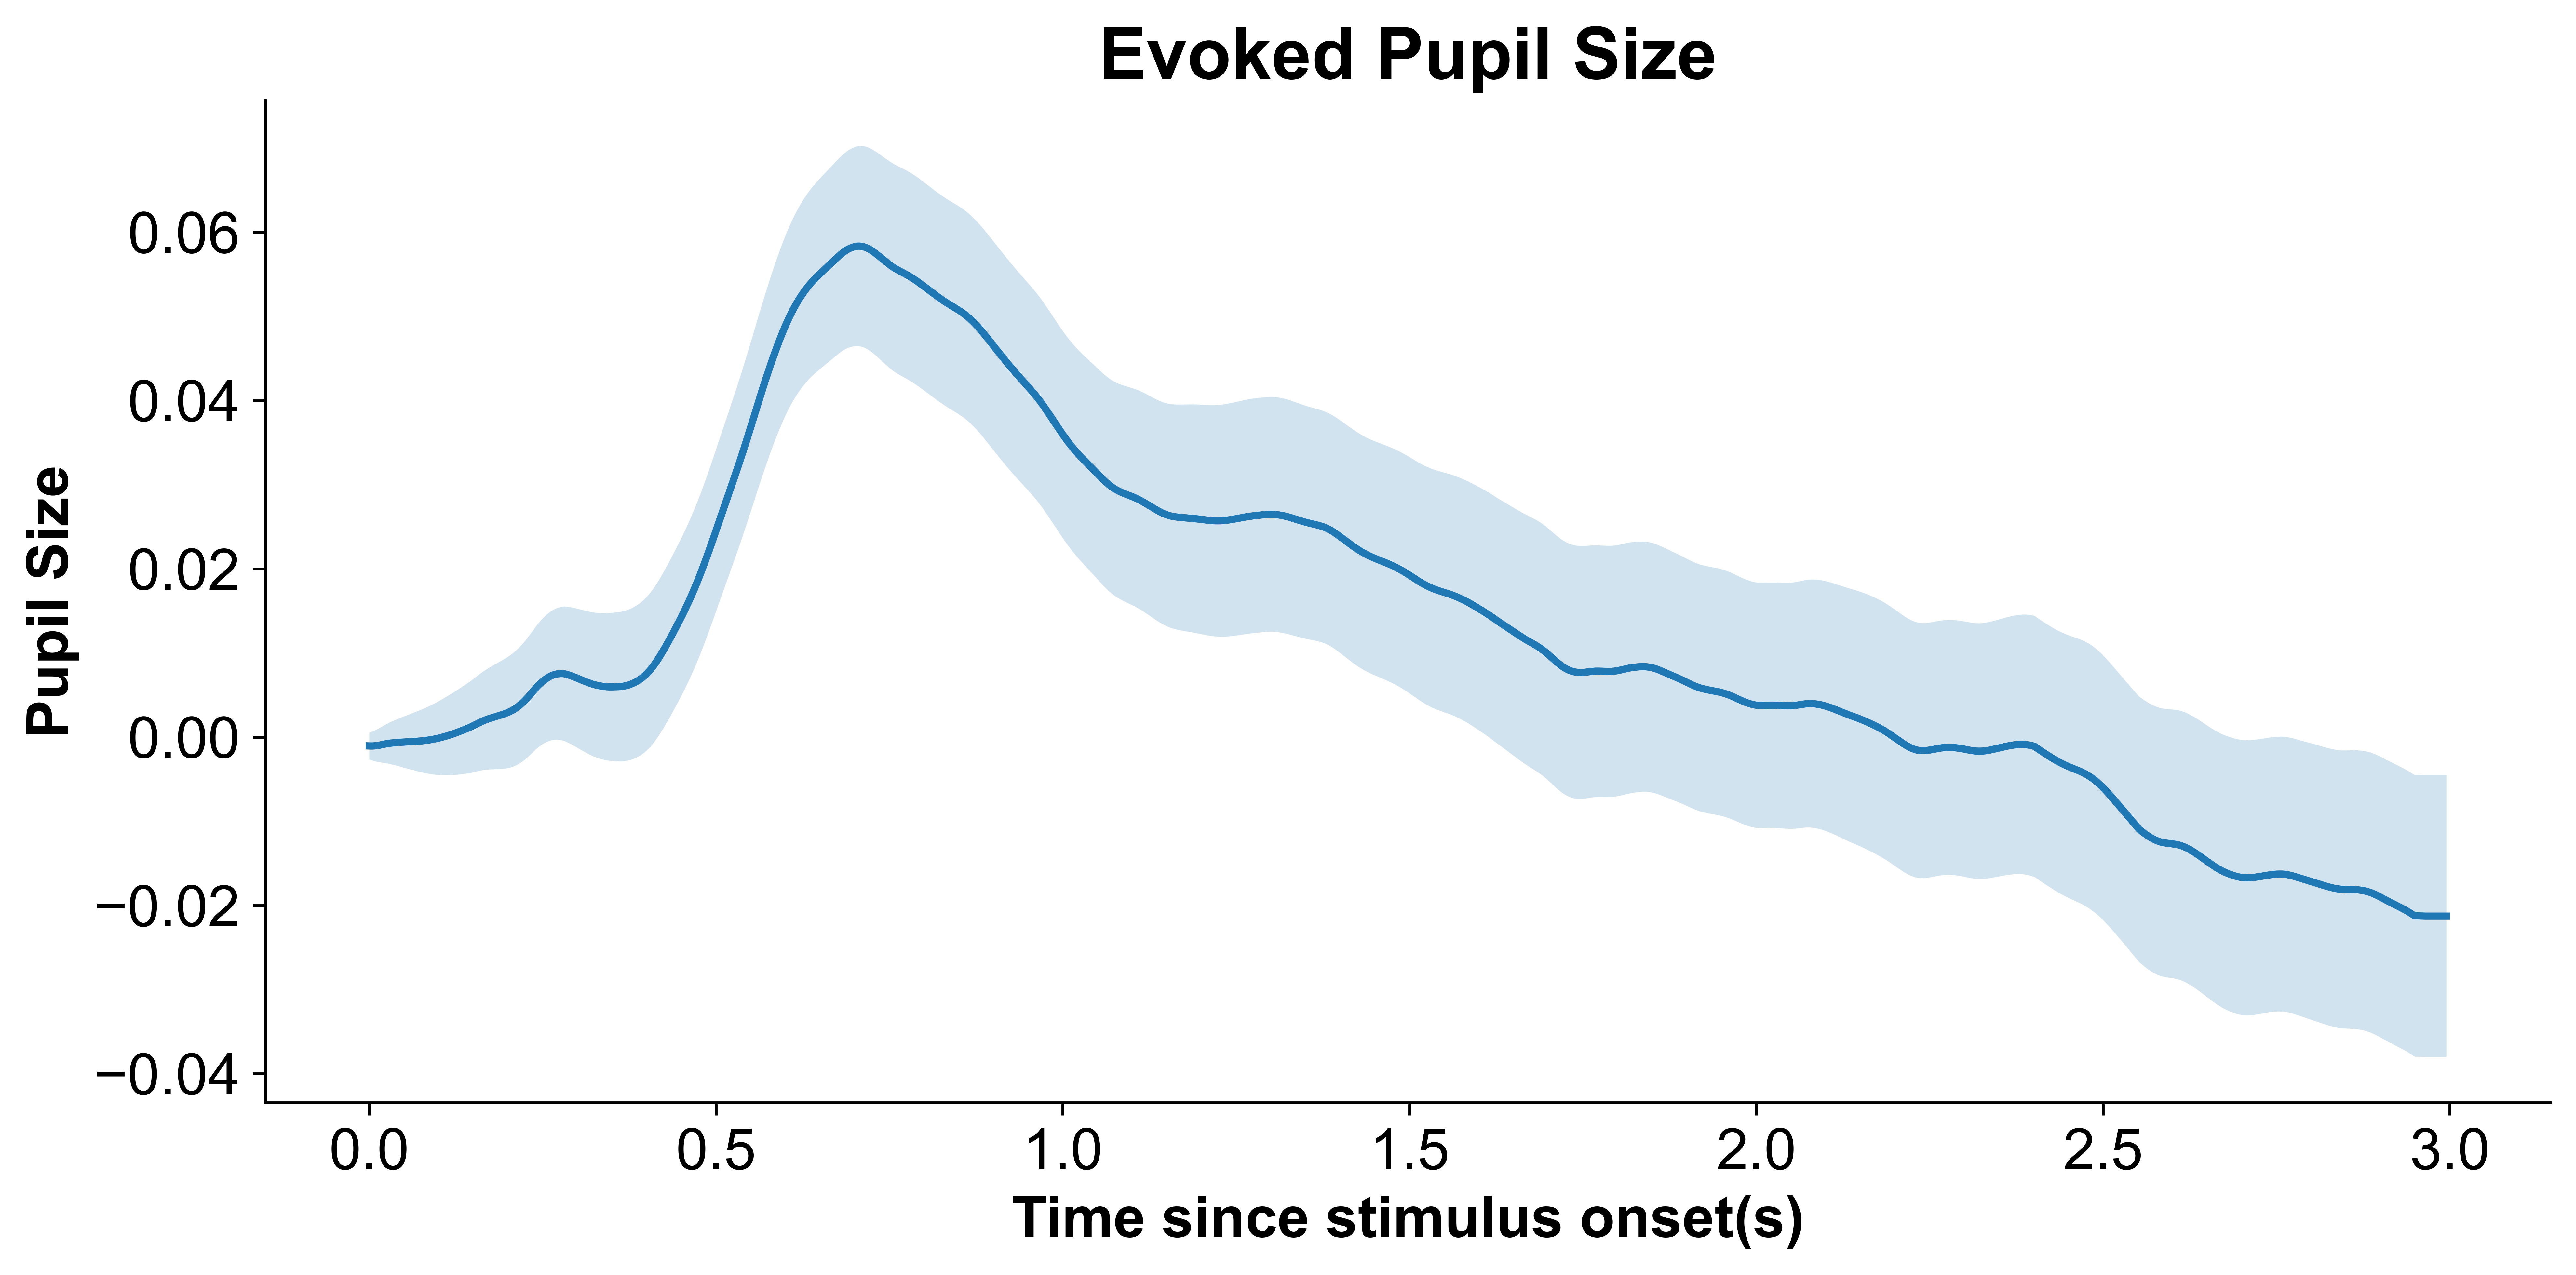

In [81]:
test_array, (fig, ax) = p.plot_evoked(data='final_data', pupil_col='pp_final', error='sem')

In [53]:
p.test_array = test_array

In [54]:
ar = test_array['all']
ar.shape

(127, 2996)

In [55]:
ci_low, ci_high = ms.bootstrap_confidence_interval(ar)

In [56]:
T_obs, clusters, cluster_p_values, H0 = ms.permutation_cluster_1samp_test(
    ar,
    n_permutations=1000,
    tail=0,
    n_jobs=-1,
    out_type="mask",
)

Using a threshold of 1.978971
stat_fun(H1): min=-1.2653334482437586 max=4.927300375421641
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

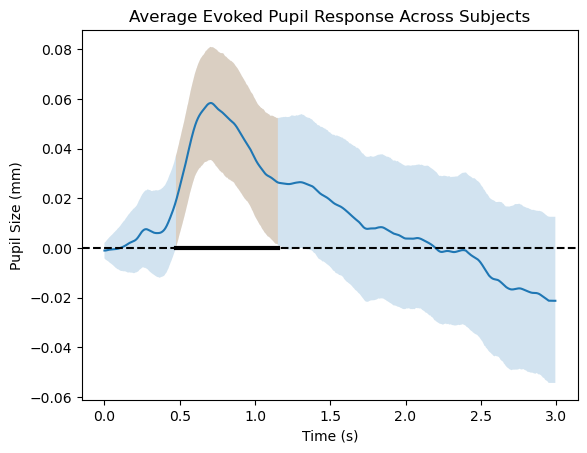

In [57]:
import matplotlib.pyplot as plt

# plot data and visualize clusters
fig, ax = plt.subplots()

t = np.arange(ar.shape[1]) / 1000
ax.plot(t, ar.mean(axis=0))
ax.fill_between(t, ci_low, ci_high, alpha=0.2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil Size (mm)')
ax.set_title('Average Evoked Pupil Response Across Subjects')

# plot clusters
for cluster in clusters:
    ax.fill_between(t[cluster], ci_low[cluster], ci_high[cluster], alpha=0.2)
    ax.plot(t[cluster], 0*np.ones(len(t[cluster])), color='black', linewidth=3)

# baseline
ax.axhline(0, color='black', linestyle='--')


In [58]:
ar2 = ar.copy()
ar2 = ar2*3

In [59]:
ci_low_ar, ci_high_ar = ms.bootstrap_confidence_interval(ar)
ci_low_ar2, ci_high_ar2 = ms.bootstrap_confidence_interval(ar2)

In [60]:
T_obs, clusters, cluster_p_values, H0 = ms.permutation_cluster_test(
    [ar, ar2],
    n_permutations=1000,
    n_jobs=-1,
    out_type="mask",
)

Using a threshold of 3.878624
stat_fun(H1): min=1.8577997250512067e-09 max=9.711315595852124
Running initial clustering …
Found 1 cluster


C:\Users\Hans Cheng\AppData\Local\Temp\ipykernel_9128\2406134511.py:1: RuntimeWarning:

Ignoring argument "tail", performing 1-tailed F-test



  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

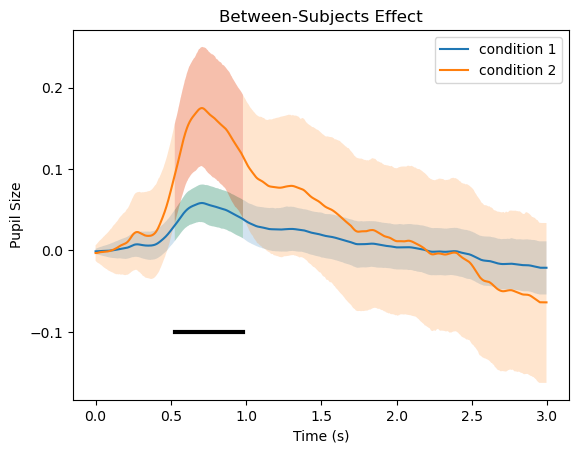

In [61]:
# plot data and visualize clusters
fig, ax = plt.subplots()

t = np.arange(ar.shape[1]) / 1000
ax.plot(t, ar.mean(axis=0), label='condition 1')
ax.plot(t, ar2.mean(axis=0), label='condition 2')

ax.fill_between(t, ci_low_ar, ci_high_ar, alpha=0.2)
ax.fill_between(t, ci_low_ar2, ci_high_ar2, alpha=0.2)

# plot clusters
for cluster in clusters:
    ax.plot(t[cluster], -.1*np.ones(len(t[cluster])), color='black', linewidth=3)
    ax.fill_between(t[cluster], ci_low_ar[cluster], ci_high_ar[cluster], alpha=0.2)
    ax.fill_between(t[cluster], ci_low_ar2[cluster], ci_high_ar2[cluster], alpha=0.2)


ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil Size')
ax.set_title('Between-Subjects Effect')
ax.legend()
